In [17]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [19]:
# 加载CIFAR-10数据集并进行预处理
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='~/.cache', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Files already downloaded and verified


In [20]:
# 创建一个简单的CNN模型（可根据需要更改）
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pooling2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pooling2(x)
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [21]:
model = Net()
model.to(device)
sums = summary(model, torch.zeros((1, 3, 32, 32)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 32, 32]          1,792
├─ReLU: 1-2                              [-1, 64, 32, 32]          --
├─Conv2d: 1-3                            [-1, 128, 32, 32]         73,856
├─ReLU: 1-4                              [-1, 128, 32, 32]         --
├─MaxPool2d: 1-5                         [-1, 128, 16, 16]         --
├─Linear: 1-6                            [-1, 512]                 16,777,728
├─Linear: 1-7                            [-1, 10]                  5,130
Total params: 16,858,506
Trainable params: 16,858,506
Non-trainable params: 0
Total mult-adds (M): 94.05
Input size (MB): 0.01
Forward/backward pass size (MB): 1.50
Params size (MB): 64.31
Estimated Total Size (MB): 65.83


In [22]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 训练模型（带有tqdm的进度条）
for epoch in range(5):  # 假设进行5个epoch的训练
    running_loss = 0.0
    correct = 0
    total = 0
    etqdm = tqdm(enumerate(trainloader, 0), total=len(trainloader))
    with etqdm as t:
        for i, data in t:
            # 获取输入数据
            inputs, labels = data[0].to(device), data[1].to(device)

            # 梯度置零
            optimizer.zero_grad()

            # 前向传播
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 统计训练信息
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # 更新进度条
            t.set_postfix(loss=loss.item())

    # 打印每个epoch结束时的损失和准确率
    avg_loss = running_loss / len(trainloader)
    tqdm.write(f'Epoch {epoch + 1}, Loss: {avg_loss:.3f}, Accuracy: {100 * correct / total:.2f}%')

print('Finished Training')

100%|██████████| 782/782 [00:11<00:00, 69.17it/s, loss=1.63]


Epoch 1, Loss: 1.830, Accuracy: 35.84%


100%|██████████| 782/782 [00:10<00:00, 73.81it/s, loss=1.2] 


Epoch 2, Loss: 1.459, Accuracy: 48.67%


100%|██████████| 782/782 [00:10<00:00, 74.96it/s, loss=0.87] 


Epoch 3, Loss: 1.281, Accuracy: 54.72%


100%|██████████| 782/782 [00:09<00:00, 78.56it/s, loss=1.02] 


Epoch 4, Loss: 1.171, Accuracy: 58.95%


100%|██████████| 782/782 [00:10<00:00, 78.04it/s, loss=1.26] 

Epoch 5, Loss: 1.076, Accuracy: 62.46%
Finished Training


In [23]:
# 创建一个示例空间注意力模块
class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(in_channels=2, out_channels=1, kernel_size=7, stride=1, padding=3, bias=False)
        self.norm = nn.BatchNorm2d(1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # 通道pooling
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_pool, max_pool], dim=1)
        # 卷积+BN+激活
        x = self.conv(x)
        x = self.norm(x)
        x = self.sigmoid(x)       
        return x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


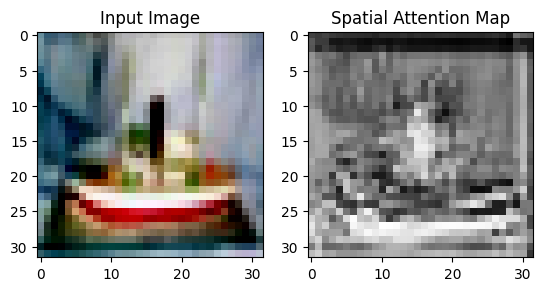

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


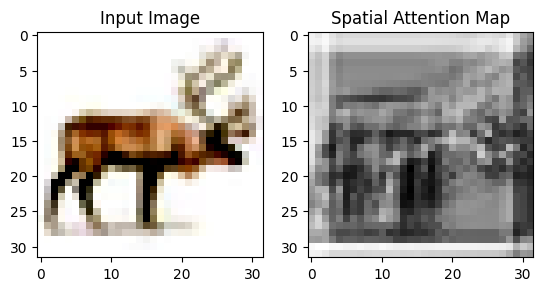

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


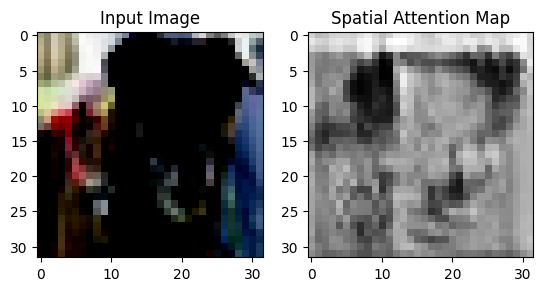

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


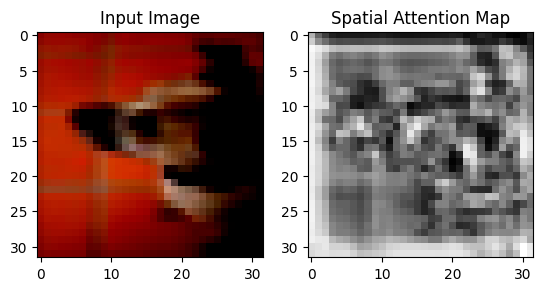

In [24]:
# 从训练集中随机选择4张图片
np.random.seed(0)
for i in range(4):
    input_data, _ = trainset[np.random.randint(0, len(trainset))]
    input_data = input_data.unsqueeze(0).to(device)
    # 使用模型提取特征
    model.eval()
    features = model.conv2(model.relu1(model.conv1(input_data)))
    # 创建一个空间注意力模块
    spatial_attention = SpatialAttention().to(device)
    # 使用空间注意力模块
    output = spatial_attention(features)

    # 可视化注意力图
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(input_data[0].cpu().numpy().transpose(1, 2, 0))
    ax[0].set_title('Input Image')
    ax[1].imshow(output[0, 0].cpu().detach().numpy(), cmap='gray')
    ax[1].set_title('Spatial Attention Map')
    plt.show()